# Sentiment Classification Project

In [56]:
import numpy as np
import pandas as pd
import torch

# Load data

In [3]:
training_data = pd.read_csv('data/training.csv',index_col = 0)

In [4]:
# Encode the Labels (either as 0,1,2 for classification or -1,0,1 for regression)
label_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
training_data['label_encoded'] = training_data['label'].map(label_mapping)

In [6]:
training_data

,sentence,label,label_encoded
id,,,
0,Those 2 drinks are part of the HK culture and ...,negative,-1
1,I was told by the repair company that was doin...,negative,-1
2,It is there to give them a good time .,neutral,0
3,Like leafing through an album of photos accomp...,negative,-1
4,Johnny was a talker and liked to have fun.,positive,1
...,...,...,...
102092,I thought this place was supposed to be good.,negative,-1
102093,They claim it's because people didn't like it ...,negative,-1
102094,There is also another marbled-out full bathroo...,neutral,0


# Build Validation Set
We use 90% of the reviews for training, and the remaining 10% for validation

In [7]:
from sklearn.model_selection import train_test_split
sentences = training_data['sentence']
labels = training_data['label_encoded']

In [27]:
# Fix Random Seed for Reproducibility
random_seed = 42
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences,labels, test_size=0.1, stratify=labels, random_state=random_seed)
train_sentences, val_sentences = list(train_sentences), list(val_sentences)
train_labels, val_labels = np.array(train_labels), np.array(val_labels)

In [29]:
from sklearn.utils import resample

# BALANCE_TRAINING = True

# Combine sentences and labels for easy manipulation
train_data = list(zip(train_sentences, train_labels))

# Separate by class
class_minus1 = [x for x in train_data if x[1] == -1]
class_0 = [x for x in train_data if x[1] == 0]
class_1 = [x for x in train_data if x[1] == 1]

# Find the smallest class size
min_size = min(len(class_minus1), len(class_0), len(class_1))

# Undersample all classes to match the smallest class
class_minus1_bal = resample(class_minus1, replace=False, n_samples=min_size, random_state=42)
class_0_bal = resample(class_0, replace=False, n_samples=min_size, random_state=42)
class_1_bal = resample(class_1, replace=False, n_samples=min_size, random_state=42)

# Combine and shuffle
balanced_train_data = class_minus1_bal + class_0_bal + class_1_bal
np.random.shuffle(balanced_train_data)

# Split back into sentences and labels
train_sentences_bal, train_labels_bal = zip(*balanced_train_data)
train_sentences_bal, train_labels_bal = list(train_sentences_bal), np.array(train_labels_bal)

# Bag-of-words + Logistic Regression baseline

In [95]:
import importlib
import embeddings
importlib.reload(embeddings) # This is so when I make changes in embeddings it will reload the changes instead of caching the old file.

# ****** change the following to access different embeddings

# embedding_model = embeddings.BOWEmbedding(ngram_range=(1, 2), max_features=10000, stop_words=None, min_df=1, max_df=1.0)  #baseline
# embedding_model = embeddings.BOWEmbedding(ngram_range=(1, 2), max_features=10000, stop_words='english', min_df=10, max_df=0.9)
# embedding_model = embeddings.TFIDFEmbedding(ngram_range=(1, 2), max_features=10000, stop_words=None, min_df=1, max_df=1.0)
embedding_model = embeddings.Bert_base_uncased()
# embedding_model = embeddings.Bert_variable_length() # This isn't working great for me
# embedding_model = embeddings.Word2VecEmbedding2("GoogleNews-vectors-negative300.bin", binary=True)


# print(type(train_sentences_bal))

n_samples = -1 # set to -1 to get all samples
X_train = embedding_model.fit_transform(train_sentences_bal[:n_samples])#For quick testing with less data
X_val = embedding_model.transform(val_sentences[:n_samples])

Y_train = train_labels_bal[:n_samples] 
Y_val = val_labels[:n_samples]

Processing batches: 100%|██████████| 320/320 [00:27<00:00, 11.63it/s]


In [88]:
# print(type(train_sentences_bal[1]))
# print(type(train_sentences_bal))
# print(type(train_sentences))
# print(type(val_labels))
# print(type(val_labels[1]))
# print(type(X_train))
# print(type(X_val))
# print(len(X_train[0]))
# print(len(X_val[0]))
# print(type(Y_train))
# print(type(Y_val))

In [17]:
# print(X_train[0])

In [96]:
from torch.utils.data import TensorDataset, DataLoader
import custom_dataloader
importlib.reload(custom_dataloader)

#Initialize Dataloader If Necessary

if embedding_model.is_variable_length:
    dataset_train = custom_dataloader.EmbeddingDataset(X_train, Y_train)
    dataset_val = custom_dataloader.EmbeddingDataset(X_val, Y_val)
    # print(len(dataset_train))
    train_loader = DataLoader(
        dataset_train,
        batch_size=16,
        shuffle=True,
        collate_fn=custom_dataloader.collate_fn,
    )
    train_loader_pred = DataLoader(
        dataset_train,
        batch_size=16,
        collate_fn=custom_dataloader.collate_fn,
    )
    val_loader = DataLoader(
        dataset_val,
        batch_size=16,
        collate_fn=custom_dataloader.collate_fn
    )

else:
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    train_loader_pred = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

In [90]:
# X_train

Now we train a logistic regression classifier...

Epoch 1/20: Train Loss: 0.2896, Acc: 0.4952 | Val Loss: 0.2402, Acc: 0.4083
Epoch 2/20: Train Loss: 0.2421, Acc: 0.5849 | Val Loss: 0.2093, Acc: 0.6444
Epoch 3/20: Train Loss: 0.2206, Acc: 0.6626 | Val Loss: 0.1952, Acc: 0.6803
Epoch 4/20: Train Loss: 0.2122, Acc: 0.6693 | Val Loss: 0.1949, Acc: 0.6815
Epoch 5/20: Train Loss: 0.2077, Acc: 0.6729 | Val Loss: 0.1887, Acc: 0.6892
Epoch 6/20: Train Loss: 0.2047, Acc: 0.6757 | Val Loss: 0.1801, Acc: 0.6925
Epoch 7/20: Train Loss: 0.2023, Acc: 0.6786 | Val Loss: 0.1852, Acc: 0.6914
Epoch 8/20: Train Loss: 0.2006, Acc: 0.6806 | Val Loss: 0.1848, Acc: 0.6917
Epoch 9/20: Train Loss: 0.1987, Acc: 0.6821 | Val Loss: 0.1863, Acc: 0.6914
Epoch 10/20: Train Loss: 0.1974, Acc: 0.6854 | Val Loss: 0.1817, Acc: 0.6955
Epoch 11/20: Train Loss: 0.1962, Acc: 0.6861 | Val Loss: 0.1817, Acc: 0.6966
Epoch 12/20: Train Loss: 0.1943, Acc: 0.6898 | Val Loss: 0.1839, Acc: 0.6941
Epoch 13/20: Train Loss: 0.1929, Acc: 0.6919 | Val Loss: 0.1801, Acc: 0.6965
Epoch 14

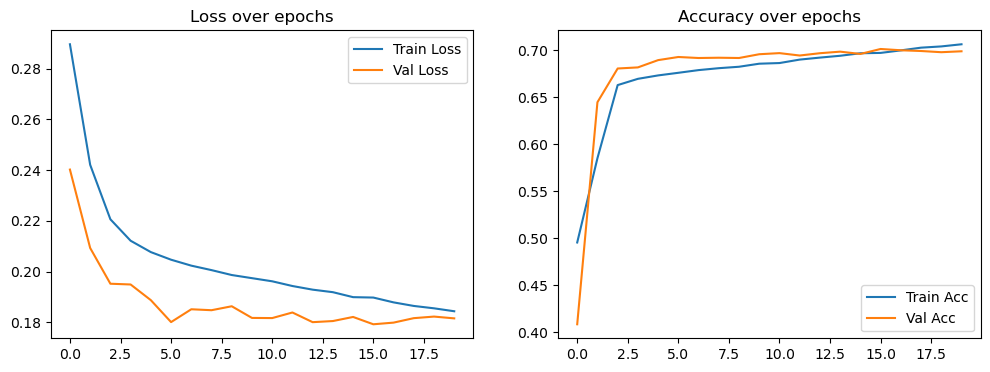

In [112]:
import models
importlib.reload(models) # needed so it doesn't cache the functions

# ******** Change this to change the model
# model = models.Logistic_Regression_Baseline() 
# model = models.LinearMLP(input_dim = X_val.shape[1])
# model = models.NonLinearMLP(input_dim = X_val.shape[1])
model = models.DropoutMLP(input_dim = X_val.shape[1], lr = 0.00005)
# model = models.LSTMClassifier(input_dim = X_val[0].shape[1], lr=0.00005, dropout=0.2, hidden_dim=256, num_layers=2)

#If model requires dataloader, Load data into dataloader:
if model.use_dataloader:
    model.fit(train_loader,val_loader,epochs=20)
else:   
    model.fit(X_train,Y_train)

In [113]:

if model.use_dataloader:
    Y_train_pred = model.predict(train_loader_pred)
    # print(type(Y_train_pred))
    # Predict on Validation Set
    Y_val_pred = model.predict(val_loader)
else: 
    Y_train_pred = model.predict(X_train)
    # Predict on Validation Set
    Y_val_pred = model.predict(X_val)

In [114]:
from sklearn.metrics import mean_absolute_error
# Score on Training Set
mae_train = mean_absolute_error(Y_train, Y_train_pred)
L_score_train = 0.5 * (2 - mae_train)
# Score on Validation Set
mae_val = mean_absolute_error(Y_val, Y_val_pred)
L_score_val = 0.5 * (2 - mae_val)

In [115]:
from sklearn.metrics import confusion_matrix
print(f'Evaluation Score (training set): {L_score_train:.05f}')
print(f'Evaluation Score (validation set): {L_score_val:.05f}')


conf_matrix = confusion_matrix(Y_train,Y_train_pred, labels=[-1, 0, 1])
print(conf_matrix)
conf_matrix = confusion_matrix(Y_val,Y_val_pred, labels=[-1, 0, 1])
print(conf_matrix)

Evaluation Score (training set): 0.82310
Evaluation Score (validation set): 0.81683
[[14060  4045  1613]
 [ 2501 15547  1671]
 [ 2368  4750 12601]]
[[1474  474  242]
 [ 703 3757  455]
 [ 421  782 1901]]


# Test Data

In [51]:
test_data = pd.read_csv('data/test.csv',index_col = 0)

In [52]:
test_data

,sentence
id,
0,Found Thai Spoon on the Vegan Pittsburgh website.
1,Our bill came out to around $27 and we ate like the wealthy.
2,State Farm broke down the costs for me of the parts and labor.
3,The only con for this resto is the wait to get a seat.
4,We could hear the people above us stomping around even after midnight.
...,...
11946,I went back in to ask for cilantro dressing the shift leader even smile or greet me.
11947,"Here , Adrian Lyne comes as close to profundity as he is likely to get ."
11948,"The actors are so terrific at conveying their young angst , we do indeed feel for them ."


In [48]:
X_test = embedding_model.transform(test_data['sentence'])


# X_Custom_test = embedding_model.transform(np.array(["if anyone wants to have the most delicious dinner, go somewhere else"]))

Processing batches: 100%|██████████| 374/374 [00:27<00:00, 13.61it/s]


In [53]:
if(embedding_model.is_variable_length):
    dataset_test = custom_dataloader.EmbeddingDataset(X_test, Y_train)
    # print(len(dataset_train))
    test_loader = DataLoader(
        dataset_train,
        batch_size=16,
        shuffle=True,
        collate_fn=custom_dataloader.collate_fn,
    )
else:
    if hasattr(X_test, 'toarray'):
        X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    else:
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    test_loader = DataLoader(TensorDataset(X_test_tensor, X_test_tensor), batch_size=32)

# print(X_test[0].shape)

if model.use_dataloader:
    y_test = model.predict(test_loader)
else: 
    y_test = model.predict(X_test)
# print(test_data.index)

# y_test = model.predict(X_Custom_test)
# print(y_test)

In [54]:
# Save predictions in the correct format
y_labels = pd.Series(y_test).map({-1: 'negative', 0: 'neutral', 1: 'positive'})
submission = pd.DataFrame({'id': test_data.index, 'label': y_labels})
submission.to_csv('test_predictions.csv', index=False) # Update filename and path as needed
print("Test predictions saved to 'test_predictions.csv'")

Test predictions saved to 'test_predictions.csv'


# Model Interpretation

In [239]:
# Top N most Important Words & Word Pairs per Output Class (Pos, Neutral, Negative)
feature_names = embedding_model.get_feature_names_out() # get names of all tokens from vectorizer
coefs = model.coef()  # Weights per Feature for each Output Class; Shape: (Num_Output_Classes, Num_Features)

# Get Top_n Features by Weight for each Class
def get_top_features(class_index, top_n=10):
    class_coef = coefs[class_index]
    top_indices = np.argsort(class_coef)[-top_n:]
    return [feature_names[i] for i in reversed(top_indices)]

print("Top words & bigrams for negative (-1):", get_top_features(0))
print("Top words & bigrams for positive (1):", get_top_features(2))
print("Top words & bigrams for neutral (0):", get_top_features(1))

AttributeError: 'Bert_base_uncased' object has no attribute 'get_feature_names_out'

In [55]:
# Confusion Matrix - Negative, Neutral, Positive
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y_val,Y_val_pred, labels=[-1, 0, 1])
print(conf_matrix)

[[1441  496  253]
 [ 650 3809  456]
 [ 390  799 1915]]


In [187]:
# Examples of Misclassified Sentences
number_examples = 5
label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}

misclassified = [
    (label_map[true], label_map[pred], text)
    for true, pred, text in zip(Y_val, Y_val_pred, val_sentences)
    if true != pred
]

import random
for true, pred, text in random.sample(misclassified, number_examples):
    print(f"True: {true}, Pred: {pred} → {text}")

True: positive, Pred: negative → We tried a trio of banana flavored dessert and I hate banana ... alas you wouldn't know that if you saw me eating this.
True: neutral, Pred: negative → It might bother people that they live far from their work place.
True: neutral, Pred: positive → He assures us that housekeeping will be up within 10 minutes to clean and sanitize the bathroom.
True: neutral, Pred: positive → A place that the concierge recommended .
True: positive, Pred: neutral → Could their be a better way to blow through 700+ Calories in one sitting?
